In [18]:
# Importaciones necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Librerías importadas exitosamente")


Librerías importadas exitosamente


In [19]:
# Cargar los datos
df = pd.read_csv('../data/processed/combined_dataset.csv')

print("Dataset cargado exitosamente!")
print(f"Dimensiones del dataset: {df.shape}")
print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Información básica del dataset
print("\n" + "="*50)
print("INFORMACIÓN GENERAL DEL DATASET")
print("="*50)
print(df.info())

print("\n" + "="*50)
print("PRIMERAS 10 FILAS")
print("="*50)
display(df.head(10))

print("\n" + "="*50)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*50)
display(df.describe())


Dataset cargado exitosamente!
Dimensiones del dataset: (34322, 7)
Memoria utilizada: 3.40 MB

INFORMACIÓN GENERAL DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34322 entries, 0 to 34321
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frame           34322 non-null  int64  
 1   landmark_index  34322 non-null  int64  
 2   x               34322 non-null  float64
 3   y               34322 non-null  float64
 4   z               34322 non-null  float64
 5   visibility      34322 non-null  float64
 6   movement        34322 non-null  object 
dtypes: float64(4), int64(2), object(1)
memory usage: 1.8+ MB
None

PRIMERAS 10 FILAS


,frame,landmark_index,x,y,z,visibility,movement
0,1,0,0.4712,0.1188,0.1986,0.9999,girar
1,1,11,0.3954,0.2537,-0.0036,0.9999,girar
2,1,12,0.5295,0.2481,0.0263,0.9999,girar
3,1,23,0.4293,0.6080,-0.0403,0.9993,girar
4,1,24,0.5095,0.5984,0.0397,0.9989,girar
5,1,25,0.4236,0.8574,-0.0526,0.8328,girar
6,1,26,0.5005,0.8476,0.0533,0.7107,girar
7,2,0,0.4696,0.1194,0.0651,0.9999,girar
8,2,11,0.3949,0.2531,-0.1725,0.9999,girar
9,2,12,0.5302,0.2471,-0.1007,0.9999,girar



ESTADÍSTICAS DESCRIPTIVAS


,frame,landmark_index,x,y,z,visibility
count,34322.0000,34322.0000,34322.0000,34322.0000,34322.0000,34322.0000
mean,50.0122,16.4913,0.5032,0.5924,-0.0554,0.9235
std,33.2431,9.3636,0.0671,0.2809,0.1633,0.1401
min,0.0000,0.0000,0.2004,-1.0758,-1.2767,0.5001
25%,23.0000,11.0000,0.4526,0.3872,-0.1211,0.9592
50%,46.0000,23.0000,0.5037,0.6279,-0.0422,0.9968
75%,72.0000,24.0000,0.5478,0.8399,0.0236,0.9993
max,169.0000,32.0000,0.8263,1.9233,0.9914,1.0000


In [20]:
# Verificar valores nulos y duplicados
print("ANÁLISIS DE CALIDAD DE DATOS")
print("="*50)

print("Valores nulos por columna:")
null_counts = df.isnull().sum()
for col, count in null_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {col}: {count} ({percentage:.2f}%)")

print(f"\nFilas duplicadas: {df.duplicated().sum()}")

# Verificar tipos de datos
print(f"\nTipos de datos:")
for col, dtype in df.dtypes.items():
    print(f"  {col}: {dtype}")

# Rango de valores para coordenadas
print(f"\nRangos de coordenadas:")
for coord in ['x', 'y', 'z']:
    min_val = df[coord].min()
    max_val = df[coord].max()
    print(f"  {coord}: [{min_val:.4f}, {max_val:.4f}]")

# Rango de visibility
print(f"\nRango de visibility: [{df['visibility'].min():.4f}, {df['visibility'].max():.4f}]")


ANÁLISIS DE CALIDAD DE DATOS
Valores nulos por columna:
  frame: 0 (0.00%)
  landmark_index: 0 (0.00%)
  x: 0 (0.00%)
  y: 0 (0.00%)
  z: 0 (0.00%)
  visibility: 0 (0.00%)
  movement: 0 (0.00%)

Filas duplicadas: 0

Tipos de datos:
  frame: int64
  landmark_index: int64
  x: float64
  y: float64
  z: float64
  visibility: float64
  movement: object

Rangos de coordenadas:
  x: [0.2004, 0.8263]
  y: [-1.0758, 1.9233]
  z: [-1.2767, 0.9914]

Rango de visibility: [0.5001, 1.0000]


In [21]:
# Análisis de distribución de movimientos
print("ANÁLISIS DE DISTRIBUCIÓN DE MOVIMIENTOS")
print("="*50)

# Conteo de cada movimiento
movement_counts = df['movement'].value_counts()
movement_percentages = df['movement'].value_counts(normalize=True) * 100

print("Distribución de movimientos:")
for movement, count in movement_counts.items():
    percentage = movement_percentages[movement]
    print(f"  {movement}: {count:,} landmarks ({percentage:.2f}%)")

print(f"\nTotal de landmarks: {len(df):,}")
print(f"Número de clases: {df['movement'].nunique()}")

# Calcular balance del dataset
min_samples = movement_counts.min()
max_samples = movement_counts.max()
balance_ratio = min_samples / max_samples
print(f"\nRatio de balance (min/max): {balance_ratio:.3f}")

if balance_ratio >= 0.8:
    print("✅ Dataset bien balanceado")
elif balance_ratio >= 0.5:
    print("⚠️ Dataset moderadamente balanceado")
else:
    print("❌ Dataset desbalanceado - considerar técnicas de balanceo")


ANÁLISIS DE DISTRIBUCIÓN DE MOVIMIENTOS
Distribución de movimientos:
  girar: 9,827 landmarks (28.63%)
  sentar: 9,429 landmarks (27.47%)
  parar: 6,321 landmarks (18.42%)
  ir al frente: 5,180 landmarks (15.09%)
  devolverse: 3,565 landmarks (10.39%)

Total de landmarks: 34,322
Número de clases: 5

Ratio de balance (min/max): 0.363
❌ Dataset desbalanceado - considerar técnicas de balanceo


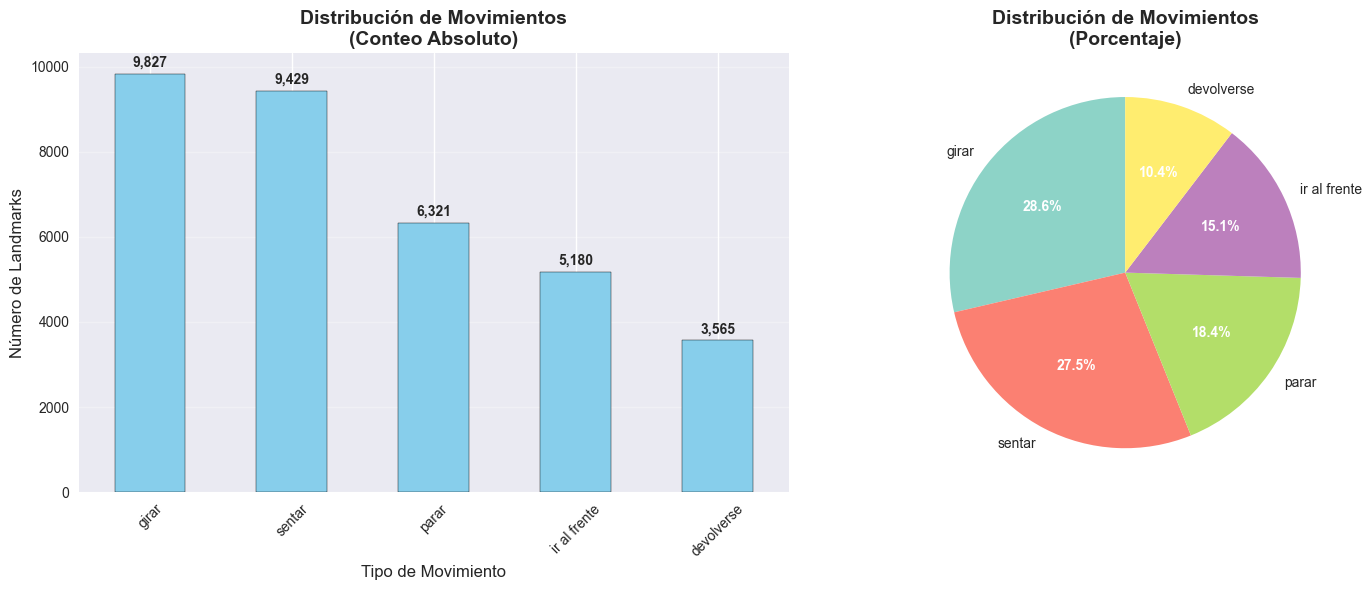

In [22]:
# Visualización de distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
movement_counts.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de Movimientos\n(Conteo Absoluto)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[0].set_ylabel('Número de Landmarks', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(movement_counts.values):
    axes[0].text(i, v + max(movement_counts)*0.01, f'{v:,}', 
                ha='center', va='bottom', fontweight='bold')

# Gráfico de pastel
colors = plt.cm.Set3(np.linspace(0, 1, len(movement_counts)))
wedges, texts, autotexts = axes[1].pie(movement_counts.values, 
                                      labels=movement_counts.index,
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      startangle=90)
axes[1].set_title('Distribución de Movimientos\n(Porcentaje)', fontsize=14, fontweight='bold')

# Mejorar la apariencia del gráfico de pastel
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()


In [23]:
# Análisis de landmarks incluidos
print("ANÁLISIS DE LANDMARKS")
print("="*50)

# Mapeo de nombres de landmarks según MediaPipe
landmark_names = {
    0: "Nariz",
    11: "Hombro Izquierdo", 
    12: "Hombro Derecho",
    23: "Cadera Izquierda", 
    24: "Cadera Derecha",
    25: "Rodilla Izquierda", 
    26: "Rodilla Derecha",
    27: "Tobillo Izquierdo", 
    28: "Tobillo Derecho",
    31: "Pie Izquierdo", 
    32: "Pie Derecho"
}

# Conteo de landmarks
landmark_counts = df['landmark_index'].value_counts().sort_index()

print("Landmarks incluidos en el dataset:")
print("-" * 40)
for landmark_idx, count in landmark_counts.items():
    name = landmark_names.get(landmark_idx, f"Landmark {landmark_idx}")
    percentage = (count / len(df)) * 100
    print(f"  {landmark_idx:2d} - {name:20s}: {count:,} ({percentage:.1f}%)")

print(f"\nTotal de landmarks únicos: {df['landmark_index'].nunique()}")

# Verificar si hay landmarks faltantes
expected_landmarks = set(landmark_names.keys())
actual_landmarks = set(df['landmark_index'].unique())
missing_landmarks = expected_landmarks - actual_landmarks

if missing_landmarks:
    print(f"\n⚠️ Landmarks faltantes: {missing_landmarks}")
else:
    print("\n✅ Todos los landmarks esperados están presentes")


ANÁLISIS DE LANDMARKS
Landmarks incluidos en el dataset:
----------------------------------------
   0 - Nariz               : 5,513 (16.1%)
  11 - Hombro Izquierdo    : 5,446 (15.9%)
  12 - Hombro Derecho      : 5,444 (15.9%)
  23 - Cadera Izquierda    : 5,233 (15.2%)
  24 - Cadera Derecha      : 5,244 (15.3%)
  25 - Rodilla Izquierda   : 3,490 (10.2%)
  26 - Rodilla Derecha     : 2,641 (7.7%)
  27 - Tobillo Izquierdo   : 351 (1.0%)
  28 - Tobillo Derecho     : 314 (0.9%)
  31 - Pie Izquierdo       : 292 (0.9%)
  32 - Pie Derecho         : 354 (1.0%)

Total de landmarks únicos: 11

✅ Todos los landmarks esperados están presentes


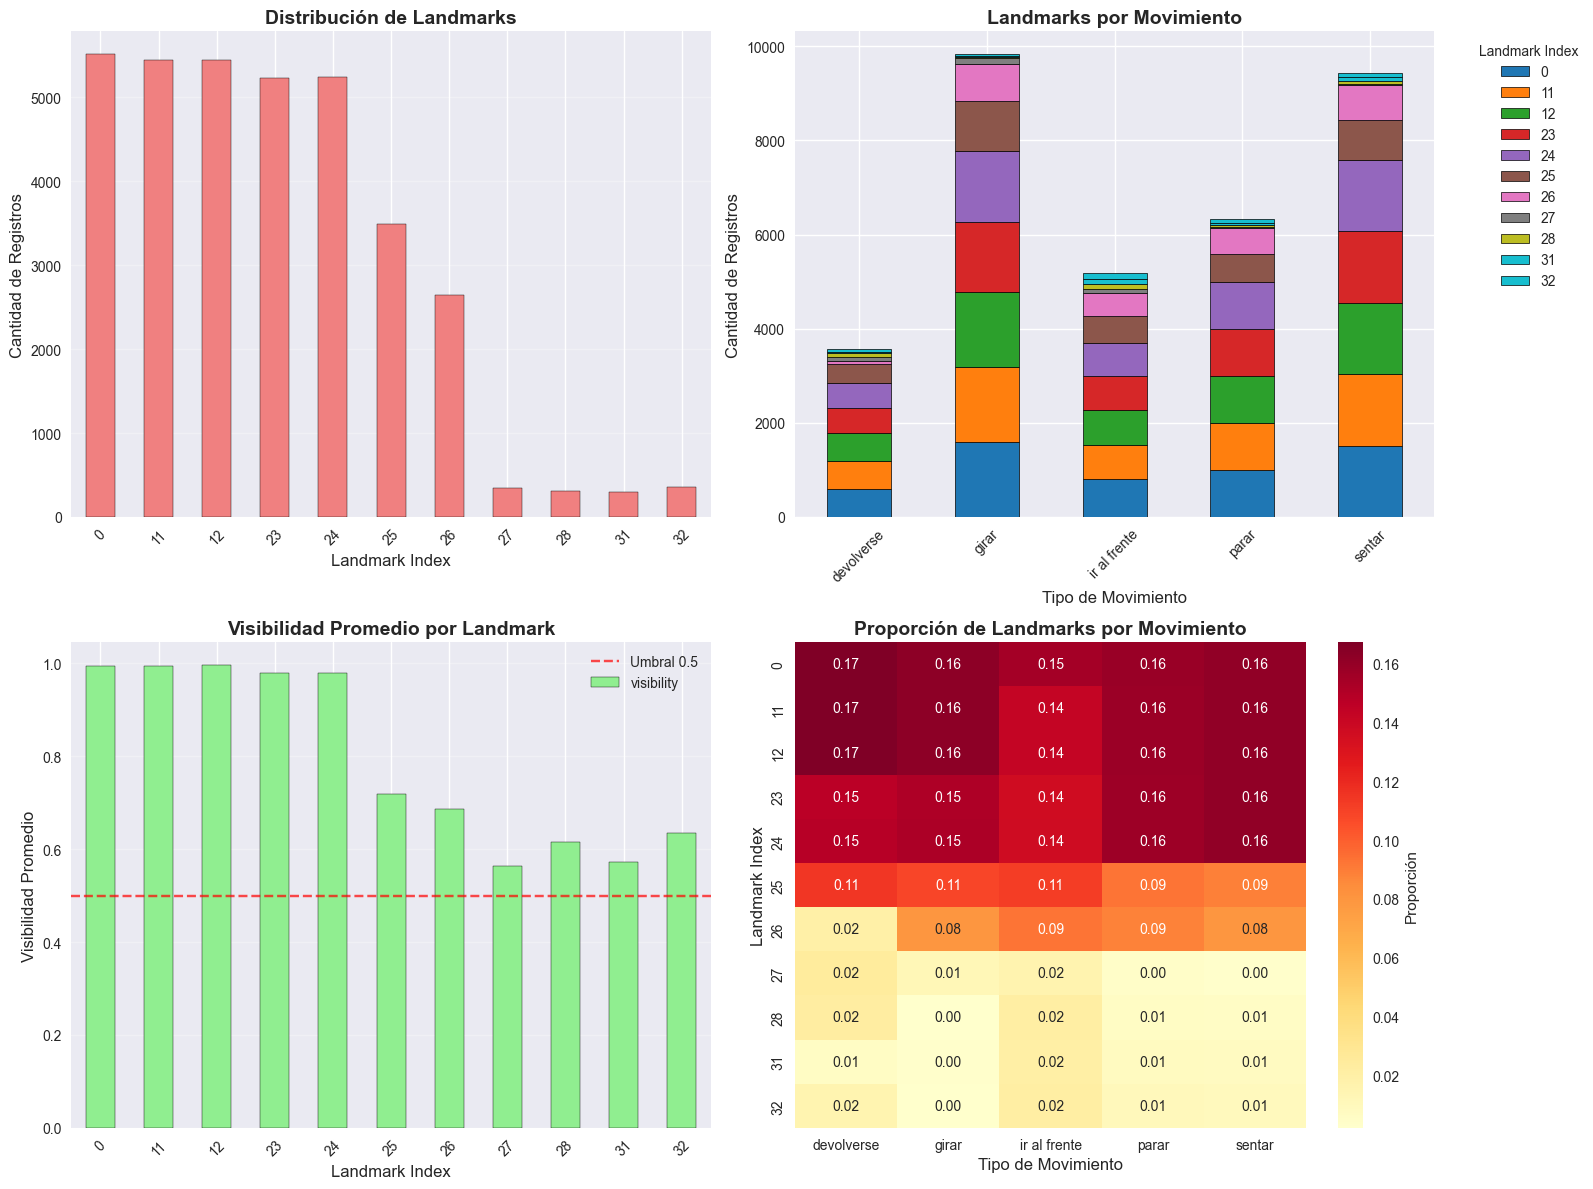

In [24]:
# Visualización de distribución de landmarks
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución general de landmarks
landmark_counts.plot(kind='bar', ax=axes[0,0], color='lightcoral', edgecolor='black')
axes[0,0].set_title('Distribución de Landmarks', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Landmark Index', fontsize=12)
axes[0,0].set_ylabel('Cantidad de Registros', fontsize=12)
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Distribución de landmarks por movimiento
landmark_movement = df.groupby(['movement', 'landmark_index']).size().unstack(fill_value=0)
landmark_movement.plot(kind='bar', ax=axes[0,1], stacked=True, 
                      colormap='tab10', edgecolor='black', linewidth=0.5)
axes[0,1].set_title('Landmarks por Movimiento', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[0,1].set_ylabel('Cantidad de Registros', fontsize=12)
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(title='Landmark Index', bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Distribución de visibility por landmark
visibility_by_landmark = df.groupby('landmark_index')['visibility'].mean()
visibility_by_landmark.plot(kind='bar', ax=axes[1,0], color='lightgreen', edgecolor='black')
axes[1,0].set_title('Visibilidad Promedio por Landmark', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Landmark Index', fontsize=12)
axes[1,0].set_ylabel('Visibilidad Promedio', fontsize=12)
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)
axes[1,0].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Umbral 0.5')
axes[1,0].legend()

# 4. Heatmap de landmarks por movimiento (normalizado)
landmark_movement_norm = landmark_movement.div(landmark_movement.sum(axis=1), axis=0)
sns.heatmap(landmark_movement_norm.T, ax=axes[1,1], annot=True, fmt='.2f', 
            cmap='YlOrRd', cbar_kws={'label': 'Proporción'})
axes[1,1].set_title('Proporción de Landmarks por Movimiento', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[1,1].set_ylabel('Landmark Index', fontsize=12)

plt.tight_layout()
plt.show()


In [25]:
# Análisis estadístico de coordenadas por movimiento
print("ANÁLISIS ESTADÍSTICO DE COORDENADAS POR MOVIMIENTO")
print("="*60)

coordinates = ['x', 'y', 'z', 'visibility']
stats_by_movement = df.groupby('movement')[coordinates].agg(['mean', 'std', 'min', 'max'])

for coord in coordinates:
    print(f"\n{coord.upper()} - Estadísticas por movimiento:")
    print("-" * 40)
    coord_stats = stats_by_movement[coord].round(4)
    display(coord_stats)

# Análisis de rangos por movimiento
print("\nRANGOS DE COORDENADAS POR MOVIMIENTO")
print("="*40)

for movement in df['movement'].unique():
    print(f"\n{movement.upper()}:")
    movement_data = df[df['movement'] == movement]
    for coord in ['x', 'y', 'z']:
        min_val = movement_data[coord].min()
        max_val = movement_data[coord].max()
        range_val = max_val - min_val
        print(f"  {coord}: [{min_val:.4f}, {max_val:.4f}] (rango: {range_val:.4f})")
    
    avg_visibility = movement_data['visibility'].mean()
    print(f"  Visibilidad promedio: {avg_visibility:.4f}")


ANÁLISIS ESTADÍSTICO DE COORDENADAS POR MOVIMIENTO

X - Estadísticas por movimiento:
----------------------------------------


,mean,std,min,max
movement,,,,
devolverse,0.5123,0.0664,0.3343,0.8263
girar,0.4963,0.0570,0.2332,0.7952
ir al frente,0.5195,0.0628,0.2004,0.8249
parar,0.5037,0.0756,0.2950,0.7895
sentar,0.4977,0.0714,0.2909,0.7350



Y - Estadísticas por movimiento:
----------------------------------------


,mean,std,min,max
movement,,,,
devolverse,0.5227,0.3365,-1.0758,1.9233
girar,0.5083,0.2976,-0.7173,1.5319
ir al frente,0.5376,0.3136,-0.5366,1.2135
parar,0.6823,0.2124,0.1802,1.2272
sentar,0.6761,0.2113,0.1811,1.2858



Z - Estadísticas por movimiento:
----------------------------------------


,mean,std,min,max
movement,,,,
devolverse,-0.0179,0.2028,-1.1026,0.9914
girar,-0.0260,0.1528,-1.1504,0.8437
ir al frente,-0.0730,0.1767,-1.2767,0.7765
parar,-0.0786,0.1550,-0.8597,0.2349
sentar,-0.0749,0.1468,-0.7599,0.3372



VISIBILITY - Estadísticas por movimiento:
----------------------------------------


,mean,std,min,max
movement,,,,
devolverse,0.9192,0.1441,0.5001,0.9998
girar,0.9259,0.1371,0.5001,1.0000
ir al frente,0.9026,0.1504,0.5003,1.0000
parar,0.9250,0.1387,0.5001,1.0000
sentar,0.9330,0.1353,0.5002,1.0000



RANGOS DE COORDENADAS POR MOVIMIENTO

GIRAR:
  x: [0.2332, 0.7952] (rango: 0.5621)
  y: [-0.7173, 1.5319] (rango: 2.2492)
  z: [-1.1504, 0.8437] (rango: 1.9940)
  Visibilidad promedio: 0.9259

SENTAR:
  x: [0.2909, 0.7350] (rango: 0.4441)
  y: [0.1811, 1.2858] (rango: 1.1047)
  z: [-0.7599, 0.3372] (rango: 1.0971)
  Visibilidad promedio: 0.9330

PARAR:
  x: [0.2950, 0.7895] (rango: 0.4945)
  y: [0.1802, 1.2272] (rango: 1.0470)
  z: [-0.8597, 0.2349] (rango: 1.0946)
  Visibilidad promedio: 0.9250

IR AL FRENTE:
  x: [0.2004, 0.8249] (rango: 0.6245)
  y: [-0.5366, 1.2135] (rango: 1.7501)
  z: [-1.2767, 0.7765] (rango: 2.0532)
  Visibilidad promedio: 0.9026

DEVOLVERSE:
  x: [0.3343, 0.8263] (rango: 0.4920)
  y: [-1.0758, 1.9233] (rango: 2.9990)
  z: [-1.1026, 0.9914] (rango: 2.0940)
  Visibilidad promedio: 0.9192


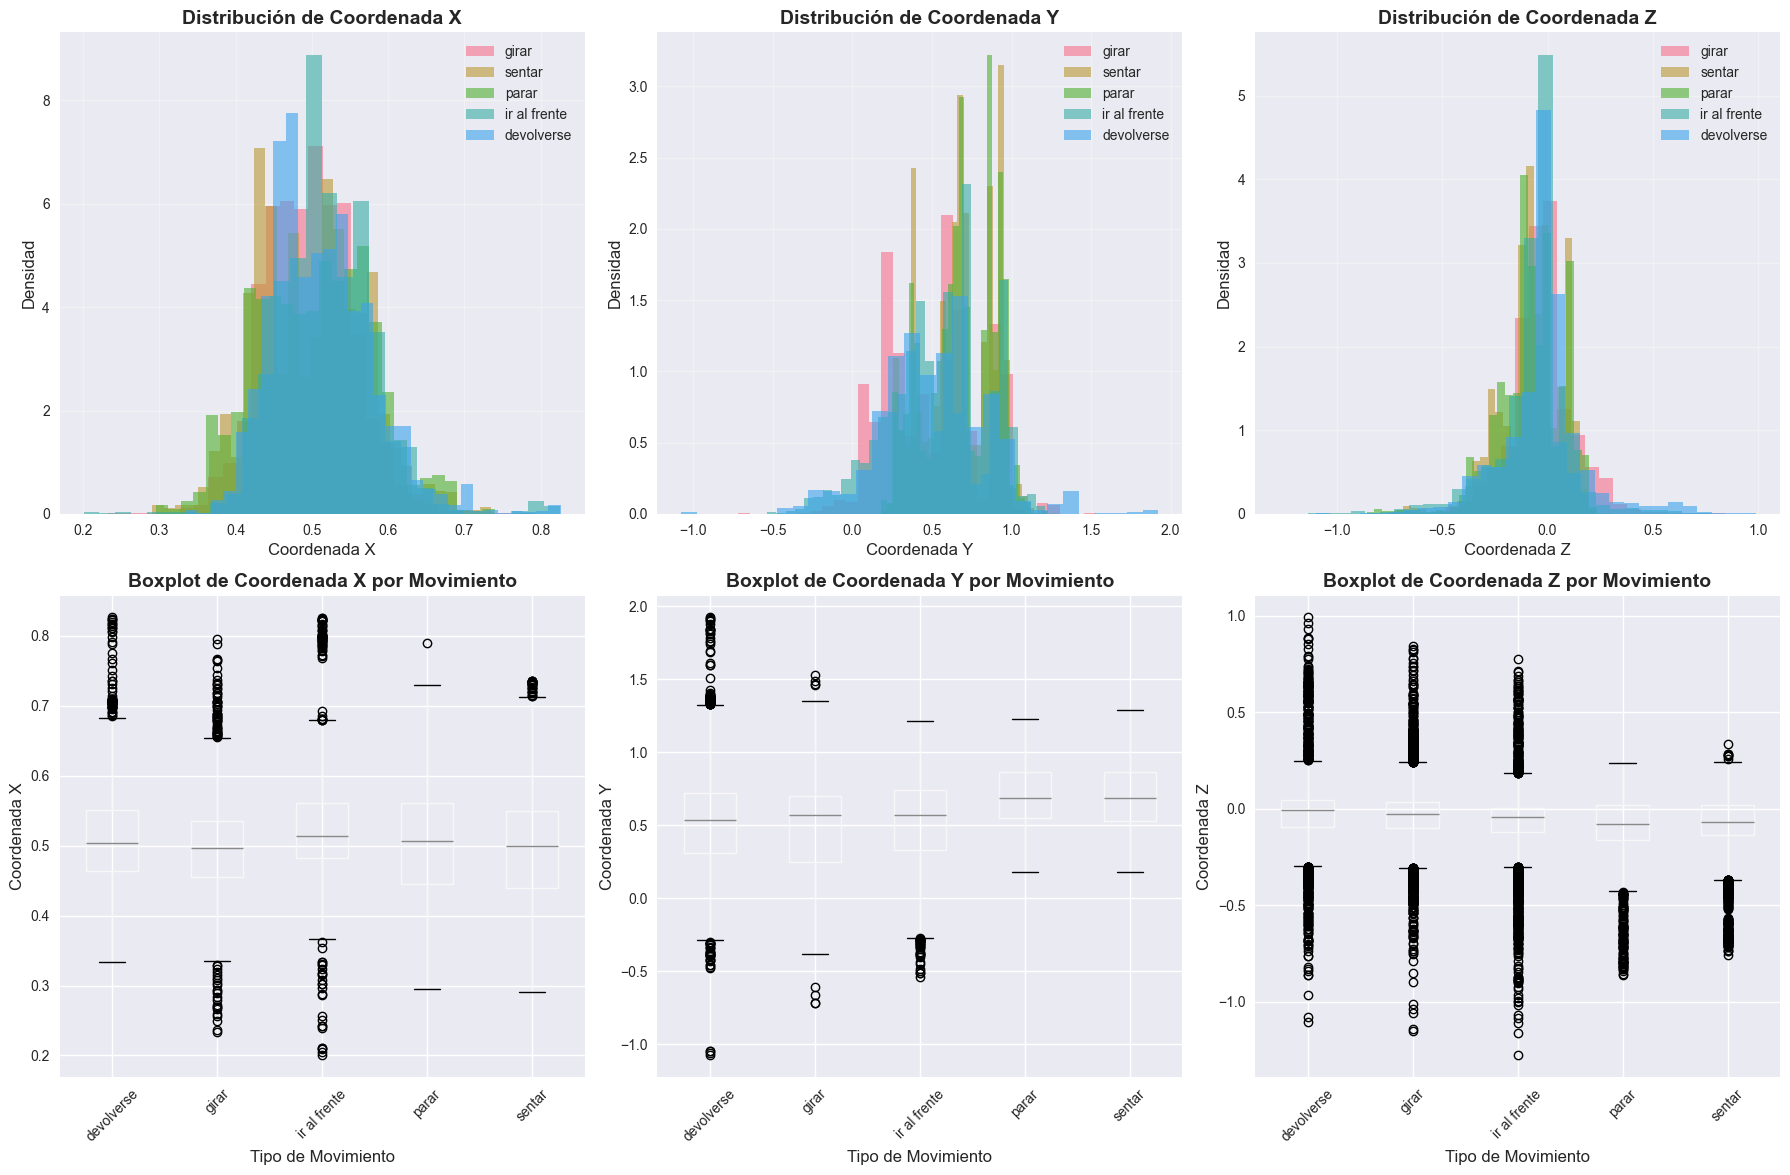

In [26]:
# Visualización de distribuciones de coordenadas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribuciones de X, Y, Z por movimiento
coordinates = ['x', 'y', 'z']
for i, coord in enumerate(coordinates):
    # Histogramas por movimiento
    for movement in df['movement'].unique():
        movement_data = df[df['movement'] == movement][coord]
        axes[0, i].hist(movement_data, alpha=0.6, label=movement, bins=30, density=True)
    
    axes[0, i].set_title(f'Distribución de Coordenada {coord.upper()}', fontsize=14, fontweight='bold')
    axes[0, i].set_xlabel(f'Coordenada {coord.upper()}', fontsize=12)
    axes[0, i].set_ylabel('Densidad', fontsize=12)
    axes[0, i].legend()
    axes[0, i].grid(alpha=0.3)

# Boxplots por movimiento
for i, coord in enumerate(coordinates):
    df.boxplot(column=coord, by='movement', ax=axes[1, i])
    axes[1, i].set_title(f'Boxplot de Coordenada {coord.upper()} por Movimiento', fontsize=14, fontweight='bold')
    axes[1, i].set_xlabel('Tipo de Movimiento', fontsize=12)
    axes[1, i].set_ylabel(f'Coordenada {coord.upper()}', fontsize=12)
    axes[1, i].tick_params(axis='x', rotation=45)

plt.suptitle('')  # Remover título automático del boxplot
plt.tight_layout()
plt.show()


In [27]:
# Análisis temporal de frames
print("ANÁLISIS TEMPORAL DE FRAMES")
print("="*40)

# Estadísticas de frames por movimiento
frame_stats = df.groupby('movement')['frame'].agg(['count', 'min', 'max', 'nunique']).round(2)
frame_stats.columns = ['Total_Landmarks', 'Frame_Min', 'Frame_Max', 'Frames_Unicos']

print("Estadísticas de frames por movimiento:")
display(frame_stats)

# Duración promedio de secuencias (asumiendo que cada frame representa un punto temporal)
print("\nDuración de secuencias por movimiento:")
for movement in df['movement'].unique():
    movement_data = df[df['movement'] == movement]
    unique_frames = movement_data['frame'].nunique()
    landmarks_per_frame = len(movement_data) / unique_frames
    print(f"  {movement}:")
    print(f"    Frames únicos: {unique_frames}")
    print(f"    Landmarks por frame: {landmarks_per_frame:.1f}")
    print(f"    Duración relativa: {unique_frames} frames")


ANÁLISIS TEMPORAL DE FRAMES
Estadísticas de frames por movimiento:


,Total_Landmarks,Frame_Min,Frame_Max,Frames_Unicos
movement,,,,
devolverse,3565,0,152,153
girar,9827,0,135,136
ir al frente,5180,0,132,133
parar,6321,0,114,115
sentar,9429,0,169,170



Duración de secuencias por movimiento:
  girar:
    Frames únicos: 136
    Landmarks por frame: 72.3
    Duración relativa: 136 frames
  sentar:
    Frames únicos: 170
    Landmarks por frame: 55.5
    Duración relativa: 170 frames
  parar:
    Frames únicos: 115
    Landmarks por frame: 55.0
    Duración relativa: 115 frames
  ir al frente:
    Frames únicos: 133
    Landmarks por frame: 38.9
    Duración relativa: 133 frames
  devolverse:
    Frames únicos: 153
    Landmarks por frame: 23.3
    Duración relativa: 153 frames


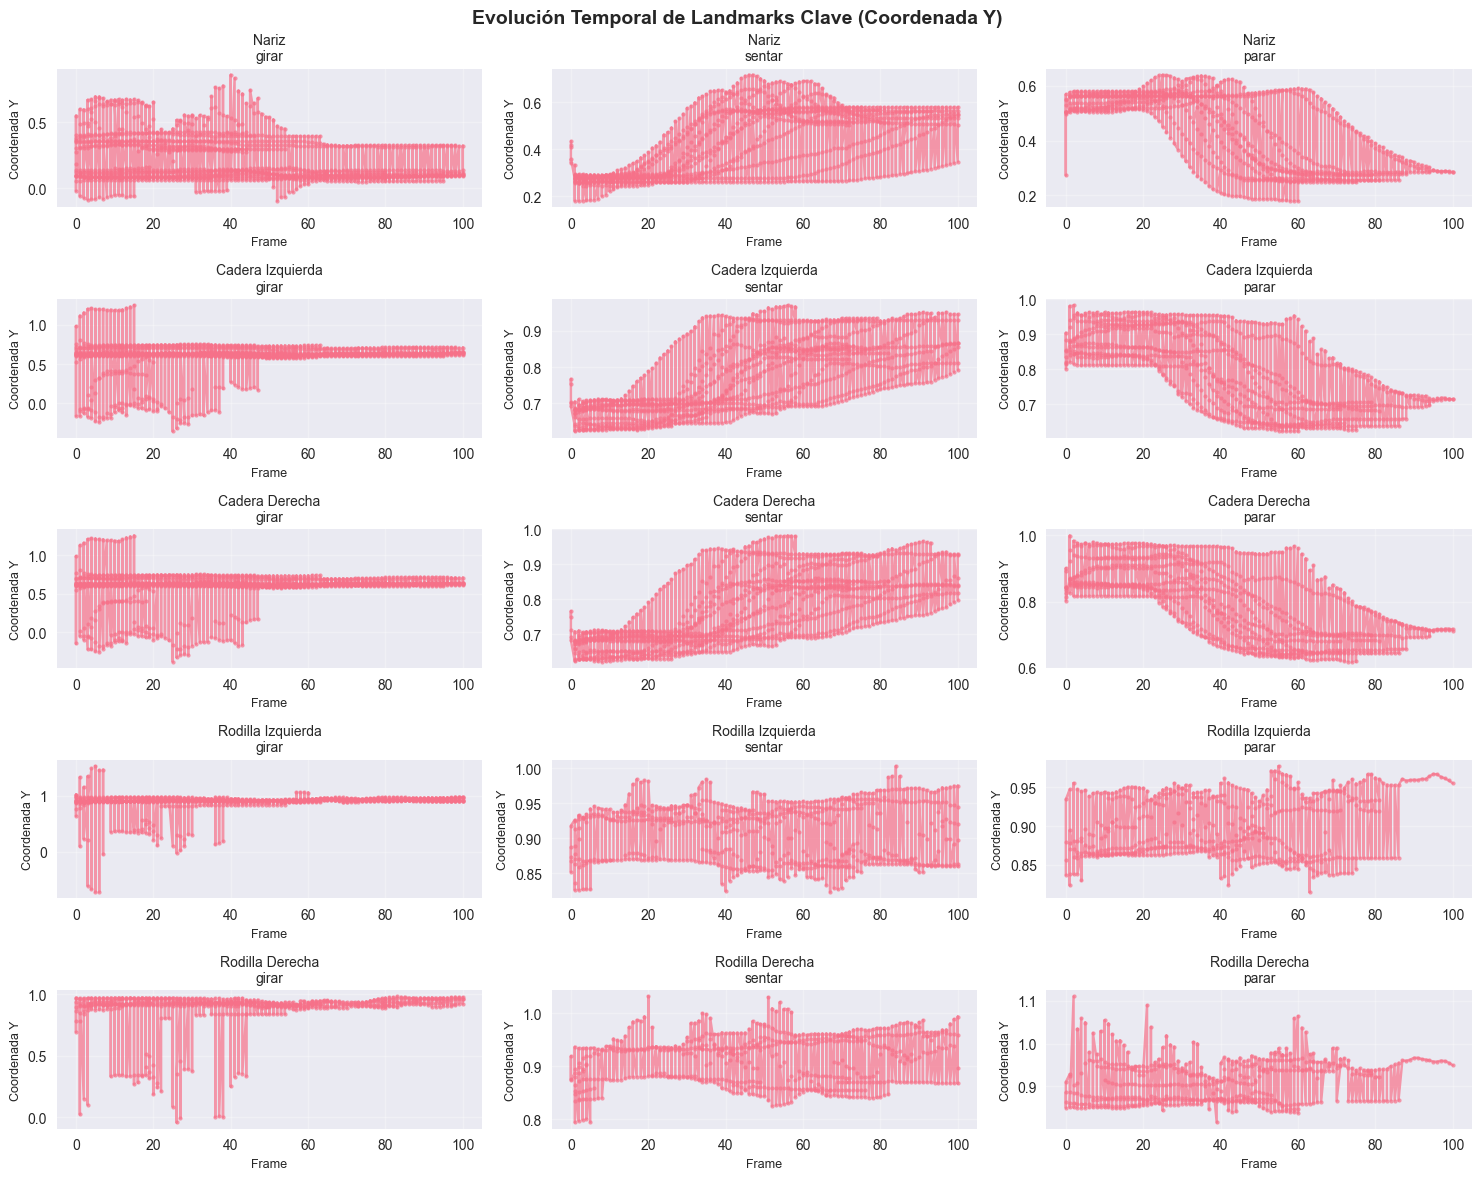

In [28]:
# Análisis de evolución temporal de landmarks clave
# Seleccionar algunos landmarks importantes y movimientos para visualizar patrones temporales

# Definir landmarks clave para análisis temporal
key_landmarks = {
    0: "Nariz",
    23: "Cadera Izquierda", 
    24: "Cadera Derecha",
    25: "Rodilla Izquierda", 
    26: "Rodilla Derecha"
}

# Tomar una muestra de datos para visualización temporal
sample_movements = ['girar', 'sentar', 'parar']
sample_size = 100  # Primeros 100 frames por movimiento

fig, axes = plt.subplots(len(key_landmarks), len(sample_movements), figsize=(15, 12))

for i, (landmark_idx, landmark_name) in enumerate(key_landmarks.items()):
    for j, movement in enumerate(sample_movements):
        # Filtrar datos para este landmark y movimiento
        subset = df[(df['landmark_index'] == landmark_idx) & 
                   (df['movement'] == movement) & 
                   (df['frame'] <= sample_size)].copy()
        
        if len(subset) > 0:
            # Ordenar por frame
            subset = subset.sort_values('frame')
            
            # Graficar evolución de coordenada Y (altura)
            axes[i, j].plot(subset['frame'], subset['y'], 'o-', alpha=0.7, markersize=3)
            axes[i, j].set_title(f'{landmark_name}\n{movement}', fontsize=10)
            axes[i, j].set_xlabel('Frame', fontsize=9)
            axes[i, j].set_ylabel('Coordenada Y', fontsize=9)
            axes[i, j].grid(alpha=0.3)
        else:
            axes[i, j].text(0.5, 0.5, 'Sin datos', ha='center', va='center', transform=axes[i, j].transAxes)
            axes[i, j].set_title(f'{landmark_name}\n{movement}', fontsize=10)

plt.suptitle('Evolución Temporal de Landmarks Clave (Coordenada Y)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


ANÁLISIS DE CORRELACIONES
Matriz de correlación entre variables numéricas:


,x,y,z,visibility
x,1.0000,-0.0190,0.0535,-0.0097
y,-0.0190,1.0000,-0.0210,-0.4925
z,0.0535,-0.0210,1.0000,0.0153
visibility,-0.0097,-0.4925,0.0153,1.0000


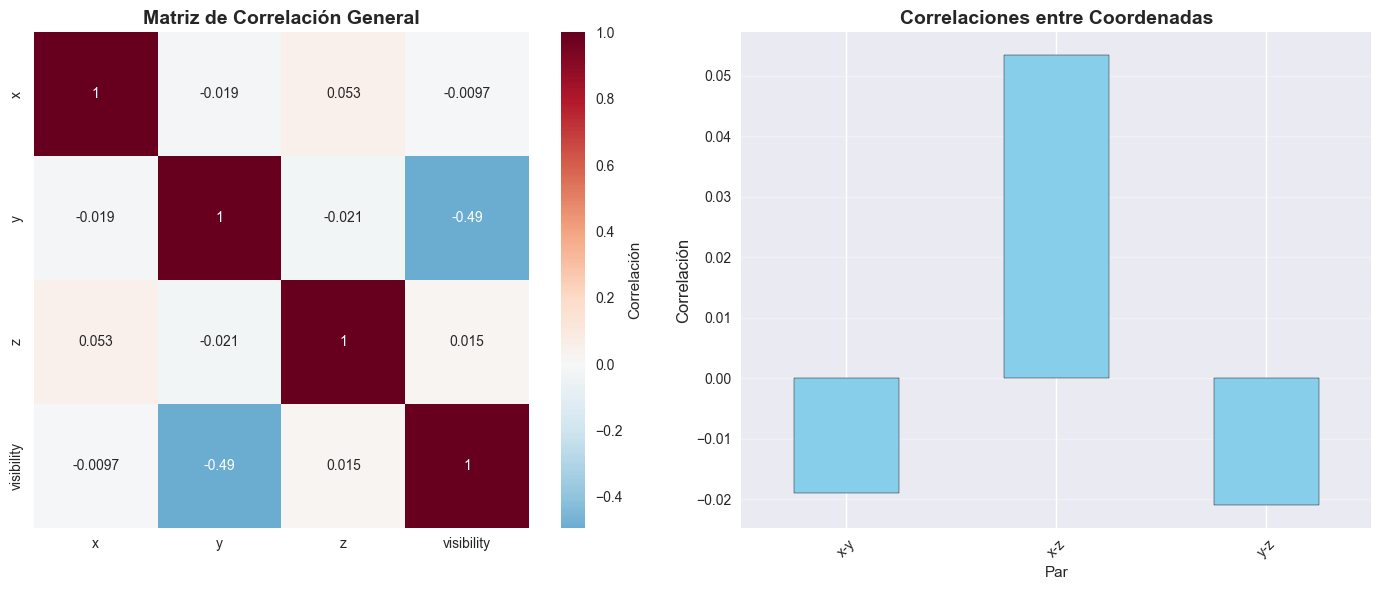

In [29]:
# Matriz de correlación entre coordenadas
print("ANÁLISIS DE CORRELACIONES")
print("="*30)

# Matriz de correlación general
corr_matrix = df[['x', 'y', 'z', 'visibility']].corr()

print("Matriz de correlación entre variables numéricas:")
display(corr_matrix.round(4))

# Visualización de matriz de correlación
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap general
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, ax=axes[0], cbar_kws={'label': 'Correlación'})
axes[0].set_title('Matriz de Correlación General', fontsize=14, fontweight='bold')

# Correlación por pares específicos
coords = ['x', 'y', 'z']
pair_correlations = []

for i in range(len(coords)):
    for j in range(i+1, len(coords)):
        coord1, coord2 = coords[i], coords[j]
        correlation = df[coord1].corr(df[coord2])
        pair_correlations.append({
            'Par': f'{coord1}-{coord2}',
            'Correlación': correlation
        })

pair_df = pd.DataFrame(pair_correlations)
pair_df.set_index('Par')['Correlación'].plot(kind='bar', ax=axes[1], color='skyblue', edgecolor='black')
axes[1].set_title('Correlaciones entre Coordenadas', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Correlación', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


CORRELACIONES ENTRE LANDMARKS ESPECÍFICOS


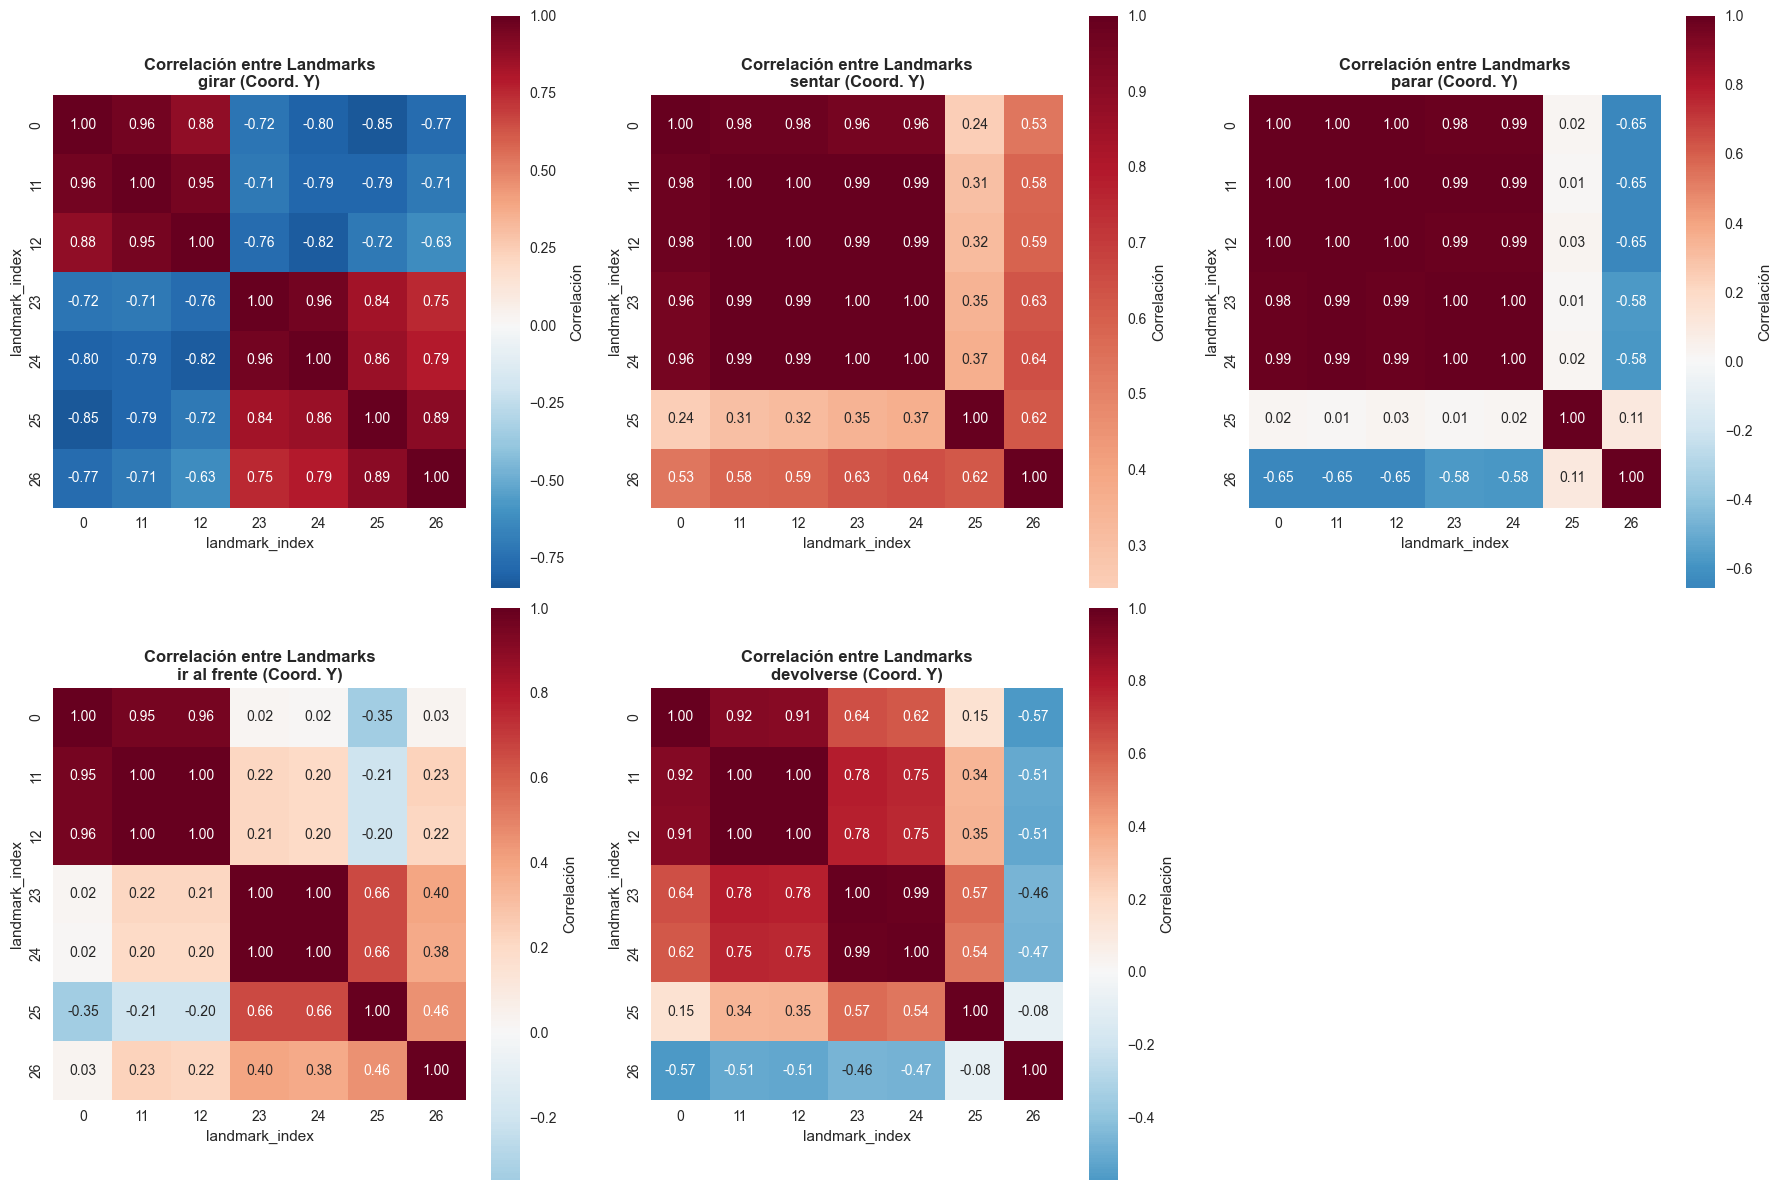

In [30]:
# Análisis de correlaciones entre landmarks específicos
# Analizar correlaciones entre landmarks clave para cada movimiento

print("CORRELACIONES ENTRE LANDMARKS ESPECÍFICOS")
print("="*45)

# Seleccionar landmarks clave para análisis de correlación
key_landmarks_list = [0, 11, 12, 23, 24, 25, 26]

# Crear dataset pivotado para análisis de correlaciones entre landmarks
def create_landmark_correlation_matrix(movement_data, coordinate='y'):
    """Crea una matriz de correlación entre landmarks para una coordenada específica"""
    pivot_data = movement_data.pivot_table(
        index='frame', 
        columns='landmark_index', 
        values=coordinate, 
        fill_value=0
    )
    
    # Filtrar solo landmarks clave que existen en los datos
    available_landmarks = [lm for lm in key_landmarks_list if lm in pivot_data.columns]
    if available_landmarks:
        return pivot_data[available_landmarks].corr()
    else:
        return None

# Analizar correlaciones por movimiento para coordenada Y (más relevante para movimientos)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

movements = df['movement'].unique()
for i, movement in enumerate(movements):
    if i < len(axes):
        movement_data = df[df['movement'] == movement]
        corr_matrix = create_landmark_correlation_matrix(movement_data, 'y')
        
        if corr_matrix is not None and not corr_matrix.empty:
            sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                       square=True, ax=axes[i], cbar_kws={'label': 'Correlación'},
                       fmt='.2f')
            axes[i].set_title(f'Correlación entre Landmarks\n{movement} (Coord. Y)', 
                            fontsize=12, fontweight='bold')
        else:
            axes[i].text(0.5, 0.5, 'Datos insuficientes', ha='center', va='center', 
                        transform=axes[i].transAxes)
            axes[i].set_title(f'{movement}\n(Sin datos suficientes)', fontsize=12)

# Ocultar ejes no utilizados
for i in range(len(movements), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


ANÁLISIS DE SEPARABILIDAD DE CLASES
Varianza explicada por cada componente:
  PC1: 0.3551 (35.51%)
  PC2: 0.1804 (18.04%)
  PC3: 0.1668 (16.68%)
Varianza acumulada: 0.7022 (70.22%)


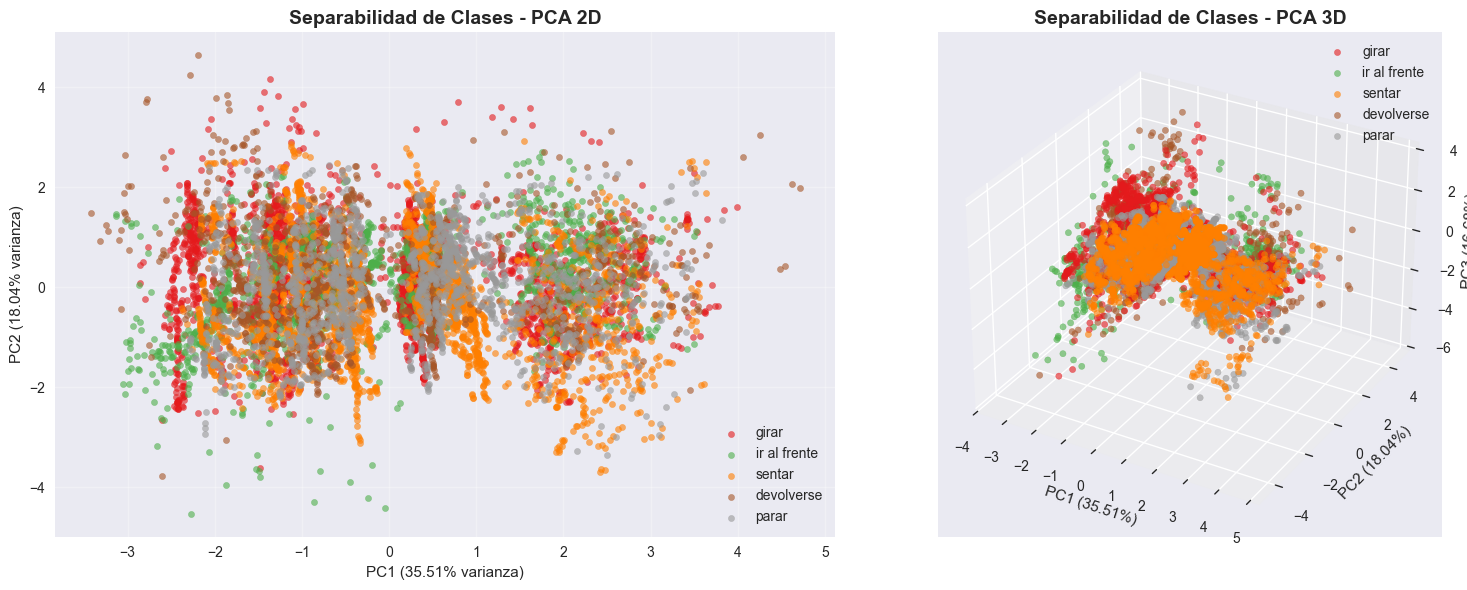

In [31]:
# Análisis de separabilidad entre clases usando PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print("ANÁLISIS DE SEPARABILIDAD DE CLASES")
print("="*40)

# Preparar datos para PCA - usar una muestra para eficiencia
sample_size = 10000  # Tomar muestra aleatoria
if len(df) > sample_size:
    df_sample = df.sample(n=sample_size, random_state=42)
else:
    df_sample = df.copy()

# Crear features para PCA
features_for_pca = ['x', 'y', 'z', 'visibility', 'landmark_index', 'frame']
X = df_sample[features_for_pca]
y = df_sample['movement']

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Aplicar PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f"Varianza explicada por cada componente:")
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var_ratio:.4f} ({var_ratio*100:.2f}%)")

print(f"Varianza acumulada: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

# Crear DataFrame para visualización
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['movement'] = y.reset_index(drop=True)

# Visualización 2D y 3D
fig = plt.figure(figsize=(16, 6))

# Plot 2D
ax1 = fig.add_subplot(121)
colors = plt.cm.Set1(np.linspace(0, 1, len(pca_df['movement'].unique())))
for i, movement in enumerate(pca_df['movement'].unique()):
    mask = pca_df['movement'] == movement
    ax1.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], 
               c=[colors[i]], label=movement, alpha=0.6, s=20)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
ax1.set_title('Separabilidad de Clases - PCA 2D', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 3D
ax2 = fig.add_subplot(122, projection='3d')
for i, movement in enumerate(pca_df['movement'].unique()):
    mask = pca_df['movement'] == movement
    ax2.scatter(pca_df[mask]['PC1'], pca_df[mask]['PC2'], pca_df[mask]['PC3'],
               c=[colors[i]], label=movement, alpha=0.6, s=20)

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
ax2.set_title('Separabilidad de Clases - PCA 3D', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()


In [32]:
# Análisis de calidad de detección de landmarks
print("ANÁLISIS DE CALIDAD DE DETECCIÓN")
print("="*40)

# Análisis de visibility por landmark y movimiento
visibility_analysis = df.groupby(['movement', 'landmark_index'])['visibility'].agg([
    'mean', 'std', 'min', 'max', 'count'
]).round(4)

print("Estadísticas de visibilidad por movimiento y landmark:")
print("(Values closer to 1.0 indicate better detection quality)")
display(visibility_analysis.head(20))

# Identificar landmarks con baja visibilidad
low_visibility_threshold = 0.5
low_visibility_landmarks = df.groupby('landmark_index')['visibility'].mean()
problematic_landmarks = low_visibility_landmarks[low_visibility_landmarks < low_visibility_threshold]

print(f"\nLandmarks con visibilidad promedio < {low_visibility_threshold}:")
if len(problematic_landmarks) > 0:
    for landmark_idx, avg_visibility in problematic_landmarks.items():
        landmark_name = landmark_names.get(landmark_idx, f"Landmark {landmark_idx}")
        print(f"  {landmark_idx} - {landmark_name}: {avg_visibility:.4f}")
else:
    print("  ✅ Todos los landmarks tienen buena visibilidad")

# Análisis de outliers en coordenadas
print(f"\nANÁLISIS DE OUTLIERS")
print("="*25)

def detect_outliers_iqr(data, column):
    """Detecta outliers usando el método IQR"""
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

for coord in ['x', 'y', 'z']:
    outliers, lower, upper = detect_outliers_iqr(df, coord)
    outlier_percentage = (len(outliers) / len(df)) * 100
    print(f"\nCoordenada {coord.upper()}:")
    print(f"  Rango normal: [{lower:.4f}, {upper:.4f}]")
    print(f"  Outliers detectados: {len(outliers):,} ({outlier_percentage:.2f}%)")
    
    if outlier_percentage > 5:
        print(f"  ⚠️ Alto porcentaje de outliers - revisar calidad de datos")
    elif outlier_percentage > 1:
        print(f"  ⚠️ Moderado porcentaje de outliers")
    else:
        print(f"  ✅ Bajo porcentaje de outliers")


ANÁLISIS DE CALIDAD DE DETECCIÓN
Estadísticas de visibilidad por movimiento y landmark:
(Values closer to 1.0 indicate better detection quality)


mean    std    min    max  count
movement   landmark_index                                   
devolverse 0              0.9905 0.0137 0.8743 0.9995    596
           11             0.9949 0.0086 0.9531 0.9998    596
           12             0.9960 0.0061 0.9677 0.9998    596
           23             0.9610 0.1002 0.5017 0.9998    523
           24             0.9579 0.1041 0.5047 0.9997    528
           25             0.7159 0.1035 0.5013 0.9752    408
           26             0.6875 0.1597 0.5003 0.9175     70
           27             0.5994 0.0536 0.5027 0.7186     88
           28             0.6261 0.0509 0.5004 0.6998     81
           31             0.5278 0.0211 0.5003 0.5635     24
           32             0.6434 0.0558 0.5001 0.7139     55
girar      0              0.9926 0.0260 0.6680 1.0000   1596
           11             0.9960 0.0109 0.9026 1.0000   1596
           12             0.9968 0.0087 0.9281 1.0000   1596
           23             0.9697 0.0825 0.5003 0.9996   1489
           24             0.9697 0.0820 0.5006 0.9995   1494
           25             0.7584 0.1004 0.5003 0.9519   1073
           26             0.6568 0.1181 0.5006 0.8999    784
           27             0.5531 0.0441 0.5005 0.7173    117
           28             0.5947 0.0663 0.5054 0.7105     22


Landmarks con visibilidad promedio < 0.5:
  ✅ Todos los landmarks tienen buena visibilidad

ANÁLISIS DE OUTLIERS

Coordenada X:
  Rango normal: [0.3099, 0.6906]
  Outliers detectados: 281 (0.82%)
  ✅ Bajo porcentaje de outliers

Coordenada Y:
  Rango normal: [-0.2919, 1.5189]
  Outliers detectados: 96 (0.28%)
  ✅ Bajo porcentaje de outliers

Coordenada Z:
  Rango normal: [-0.3382, 0.2407]
  Outliers detectados: 2,443 (7.12%)
  ⚠️ Alto porcentaje de outliers - revisar calidad de datos


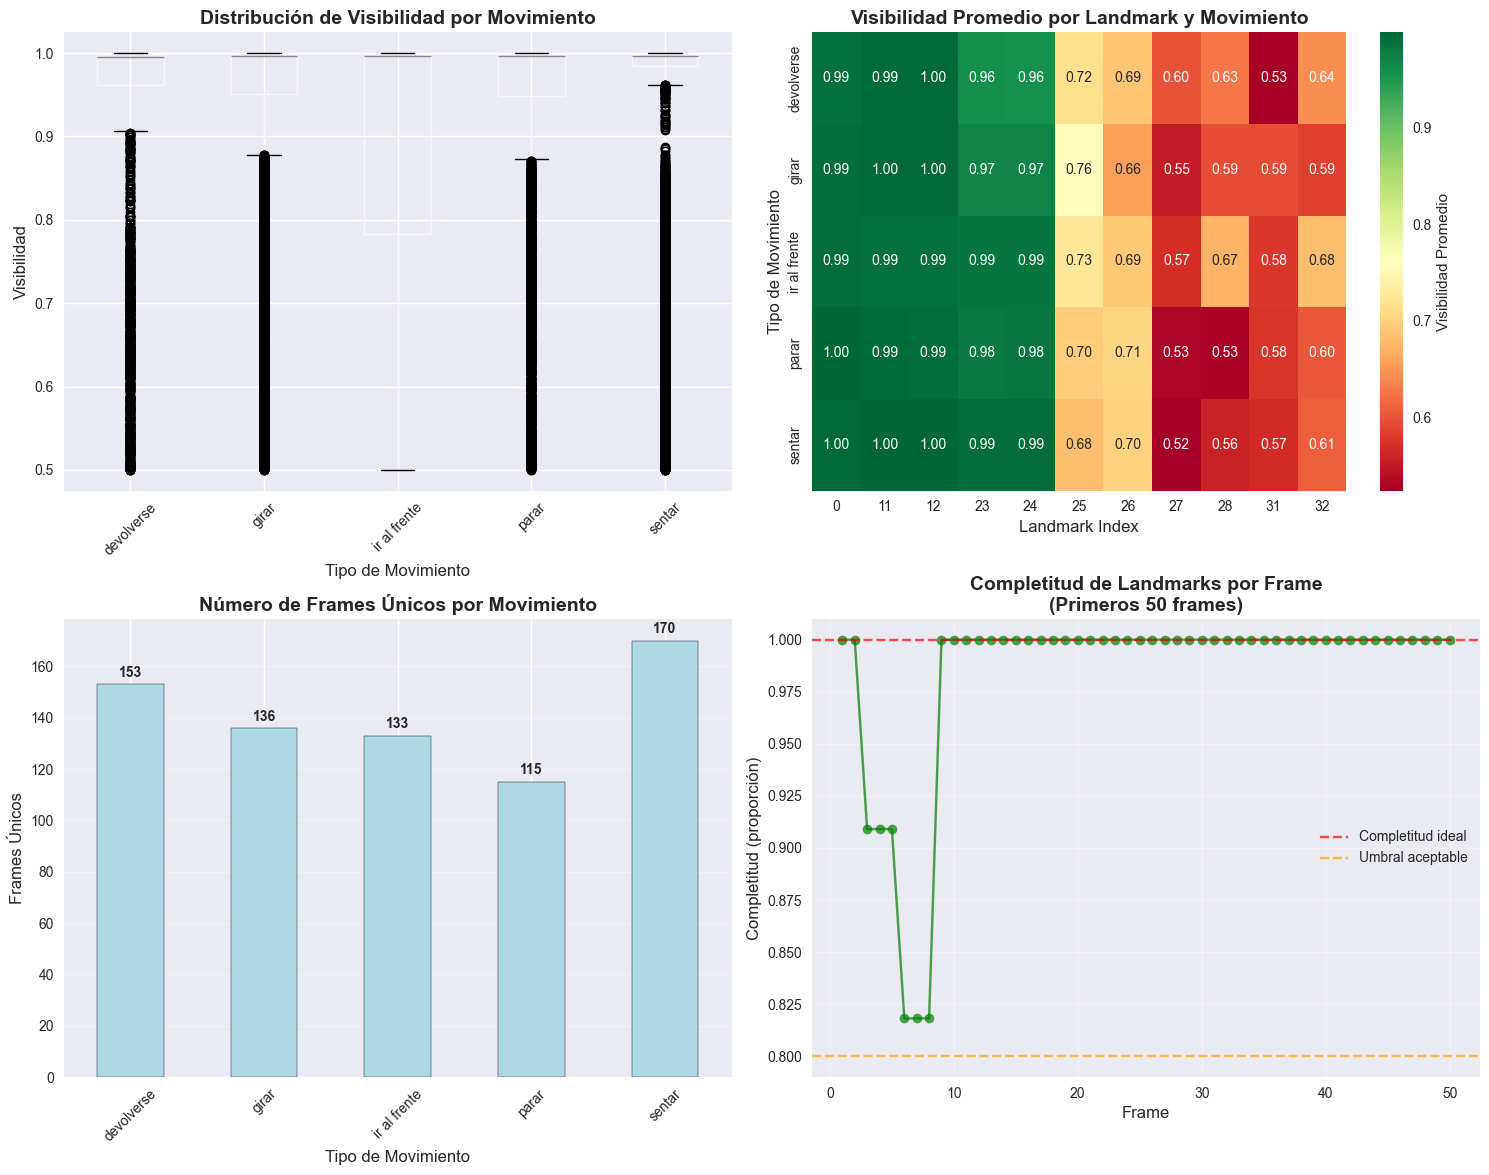

In [33]:
# Visualización de calidad de datos
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución de visibility por movimiento
df.boxplot(column='visibility', by='movement', ax=axes[0,0])
axes[0,0].set_title('Distribución de Visibilidad por Movimiento', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[0,0].set_ylabel('Visibilidad', fontsize=12)
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Heatmap de visibilidad por landmark y movimiento
visibility_heatmap = df.groupby(['movement', 'landmark_index'])['visibility'].mean().unstack()
sns.heatmap(visibility_heatmap, annot=True, cmap='RdYlGn', ax=axes[0,1], 
            cbar_kws={'label': 'Visibilidad Promedio'}, fmt='.2f')
axes[0,1].set_title('Visibilidad Promedio por Landmark y Movimiento', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Landmark Index', fontsize=12)
axes[0,1].set_ylabel('Tipo de Movimiento', fontsize=12)

# 3. Distribución de frames por movimiento
frame_counts_by_movement = df.groupby('movement')['frame'].nunique()
frame_counts_by_movement.plot(kind='bar', ax=axes[1,0], color='lightblue', edgecolor='black')
axes[1,0].set_title('Número de Frames Únicos por Movimiento', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Tipo de Movimiento', fontsize=12)
axes[1,0].set_ylabel('Frames Únicos', fontsize=12)
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(frame_counts_by_movement.values):
    axes[1,0].text(i, v + max(frame_counts_by_movement)*0.01, f'{v}', 
                  ha='center', va='bottom', fontweight='bold')

# 4. Completitud de landmarks por frame (muestra)
sample_frames = df['frame'].unique()[:50]  # Primeros 50 frames
completeness_data = []

for frame in sample_frames:
    frame_data = df[df['frame'] == frame]
    unique_landmarks = frame_data['landmark_index'].nunique()
    total_expected = len(landmark_names)
    completeness = unique_landmarks / total_expected
    completeness_data.append(completeness)

axes[1,1].plot(sample_frames, completeness_data, 'o-', color='green', alpha=0.7)
axes[1,1].set_title('Completitud de Landmarks por Frame\n(Primeros 50 frames)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Frame', fontsize=12)
axes[1,1].set_ylabel('Completitud (proporción)', fontsize=12)
axes[1,1].grid(alpha=0.3)
axes[1,1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Completitud ideal')
axes[1,1].axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='Umbral aceptable')
axes[1,1].legend()

plt.suptitle('')  # Remover título automático
plt.tight_layout()
plt.show()


In [34]:
# Resumen ejecutivo del análisis
print("="*60)
print("RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS")
print("="*60)

print(f"\n📊 DIMENSIONES DEL DATASET:")
print(f"   • Total de registros: {len(df):,}")
print(f"   • Landmarks únicos: {df['landmark_index'].nunique()}")
print(f"   • Frames únicos: {df['frame'].nunique():,}")
print(f"   • Clases de movimiento: {df['movement'].nunique()}")

print(f"\n🎯 DISTRIBUCIÓN DE CLASES:")
for movement, count in movement_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   • {movement}: {count:,} ({percentage:.1f}%)")

print(f"\n📈 CALIDAD DE DATOS:")
null_percentage = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
duplicates_percentage = (df.duplicated().sum() / len(df)) * 100
avg_visibility = df['visibility'].mean()

print(f"   • Valores nulos: {null_percentage:.2f}%")
print(f"   • Registros duplicados: {duplicates_percentage:.2f}%")
print(f"   • Visibilidad promedio: {avg_visibility:.3f}")

print(f"\n🔍 CARACTERÍSTICAS DE LOS DATOS:")
for coord in ['x', 'y', 'z']:
    coord_range = df[coord].max() - df[coord].min()
    coord_std = df[coord].std()
    print(f"   • Coordenada {coord.upper()}: rango={coord_range:.4f}, std={coord_std:.4f}")

# Balance del dataset
balance_ratio = movement_counts.min() / movement_counts.max()
print(f"\n⚖️ BALANCE DEL DATASET:")
print(f"   • Ratio de balance: {balance_ratio:.3f}")
if balance_ratio >= 0.8:
    print("   • Estado: ✅ Bien balanceado")
elif balance_ratio >= 0.5:
    print("   • Estado: ⚠️ Moderadamente balanceado")
else:
    print("   • Estado: ❌ Desbalanceado")

print(f"\n🎯 SEPARABILIDAD DE CLASES:")
print(f"   • Análisis PCA realizado con {len(df_sample):,} muestras")
print(f"   • Varianza explicada (3 componentes): {pca.explained_variance_ratio_.sum():.2%}")
print(f"   • Las clases muestran cierta separabilidad en el espacio PCA")


RESUMEN EJECUTIVO - ANÁLISIS EXPLORATORIO DE DATOS

📊 DIMENSIONES DEL DATASET:
   • Total de registros: 34,322
   • Landmarks únicos: 11
   • Frames únicos: 170
   • Clases de movimiento: 5

🎯 DISTRIBUCIÓN DE CLASES:
   • girar: 9,827 (28.6%)
   • sentar: 9,429 (27.5%)
   • parar: 6,321 (18.4%)
   • ir al frente: 5,180 (15.1%)
   • devolverse: 3,565 (10.4%)

📈 CALIDAD DE DATOS:
   • Valores nulos: 0.00%
   • Registros duplicados: 0.00%
   • Visibilidad promedio: 0.923

🔍 CARACTERÍSTICAS DE LOS DATOS:
   • Coordenada X: rango=0.6259, std=0.0671
   • Coordenada Y: rango=2.9990, std=0.2809
   • Coordenada Z: rango=2.2682, std=0.1633

⚖️ BALANCE DEL DATASET:
   • Ratio de balance: 0.363
   • Estado: ❌ Desbalanceado

🎯 SEPARABILIDAD DE CLASES:
   • Análisis PCA realizado con 10,000 muestras
   • Varianza explicada (3 componentes): 70.22%
   • Las clases muestran cierta separabilidad en el espacio PCA
